# Project Solution Lab 2: 

# 问题：预测信用卡欺诈 

## 业务场景简介
您在一家跨国银行工作。在过去的几个月里，遭遇信用卡欺诈的客户数量显著增加。一家大型新闻媒体最近甚至发表了一篇关于您和其他银行正在经历的信用卡欺诈的报道。

面对这一情况，您需要在欺诈性信用卡交易给公司造成更严重的影响之前，利用机器学习来识别这类交易，从而解决部分问题。您已经获得了对过去信用卡交易数据集的访问权限，您可以使用该数据集训练一个机器学习模型，来预测交易是否属于欺诈性交易。


## 关于该数据集
该数据集包含欧洲持卡人在 2013 年 9 月通过信用卡进行的交易。该数据集展示了两天内发生的交易，包括欺诈性交易和合法交易的样本。

### 特征
该数据集包含超过 30 个数值特征，由于数据的个人隐私问题，大部分特征都经过了主成分分析 (PCA) 转换。未经过 PCA 转换的特征只有 'Time' 和 'Amount'。特征 'Time' 包含数据集中每笔交易与第一笔交易之间经过的秒数。特征 'Amount' 是交易金额。'Class' 是响应或目标变量，如果存在欺诈，则取值 '1'，否则取值 '0'。

特征： 
`V1, V2, ...V28`：使用 PCA 获得的主成分

非 PCA 特征：
- `Time`：数据集中每笔交易与第一笔交易之间经过的秒数，$T_x - t_0$
- `Amount`：交易金额；此特征可用于基于样本的代价敏感学习 
- `Class`：目标变量，如果存在欺诈，则 `Fraud = 1`，否则 `Not Fraud = 0`

### 数据集属性
网站：https://www.openml.org/d/1597

Twitter：https://twitter.com/dalpozz/status/645542397569593344

作者：Andrea Dal Pozzolo、Olivier Caelen 和 Gianluca Bontempi
来源：信用卡欺诈检测 – 2015 年 6 月 25 日
官方引文：Andrea Dal Pozzolo、Olivier Caelen、Reid A. Johnson 和 Gianluca Bontempi。Calibrating Probability with Undersampling for Unbalanced Classification（利用欠采样解决不平衡分类问题来实现概率校准）。在 2015 年 IEEE 计算智能和数据挖掘 (CIDM) 学术研讨会上的发言。

该数据集是由 Worldline 公司和比利时布鲁塞尔大学 (ULB) 机器学习小组 (mlg.ulb.ac.be) 在有关大数据挖掘和欺诈检测的研究合作期间进行收集和分析的。有关相关主题的当前和过去项目的更多详细信息，请访问 http://mlg.ulb.ac.be/BruFence 和 http://mlg.ulb.ac.be/ARTML。

# 步骤 1：问题定义和数据收集

在开始这个项目时，先在下面用几句话来总结在这个场景中要解决的业务问题和要实现的业务目标。同时说明您想让自己的团队衡量的业务指标。确定这些信息后，请清楚地写出机器学习问题陈述。最后，添加一两条备注，说明问题陈述所对应的机器学习的类型。

#### <span style="color: blue;">项目演示：在项目演示中总结这些详细信息。</span>

### 通读业务场景，然后：

### 1.确定 ML 是否是适合部署的解决方案以及原因。
\# 在此处写下答案

### 2.定义业务问题、成功指标和期望的 ML 输出。
\# 在此处写下答案

### 3.确定您要解决的 ML 问题的类型。
\# 在此处写下答案

### 4.分析您要使用的数据是否合适。
\# 在此处写下答案


### 设置

我们已经确定了工作重点，现在我们来进行一些设置，以便开始解决问题。

**注意：**该笔记本是在 `ml.m4.xlarge` 笔记本实例上创建和测试的。

In [1]:
# 导入各种 Python 库

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

sns.set()
%matplotlib inline

In [2]:
# 安装 imblearn
!pip uninstall scikit-learn -y
!pip install imbalanced-learn==0.5.0
!pip install imblearn

Uninstalling scikit-learn-0.22.1:
  Successfully uninstalled scikit-learn-0.22.1
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/d1/48/e9fa9e252abcd1447eff6f9257636af31758a6e46fd5ce5d3c879f6907cb/scikit_learn-0.22.1-cp36-cp36m-manylinux1_x86_64.whl
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### 下载数据集

In [3]:
# 检查文件是否已位于所需路径中，或者是否需要下载
import os
import subprocess
base_path = '/home/ec2-user/SageMaker/project/data/FraudDetection'
file_path = '/fraud.csv'

if not os.path.isfile(base_path + file_path):
    subprocess.run(['mkdir', '-p', base_path])
    subprocess.run(['aws', 's3', 'cp',
                    's3://aws-tc-largeobjects/ILT-TF-200-MLDWTS/credit_card_project/',
                    base_path,'--recursive'])
else:
    print('File already downloaded!')

# 步骤 2：数据预处理和可视化 
在数据预处理阶段，您应该利用机会探索数据并将其可视化，以便更好地了解数据。首先，导入必要的库并将数据读入 Pandas dataframe。然后，探索数据。查看数据集的形状，探索要使用的列及其类型（数值型、分类型）。对各项特征执行基本统计，以便了解特征的均值和范围；深入分析目标列并确定其分布。

### 要考虑的特定问题
1.您可以从对特征执行的基本统计中推断出什么？ 

2.您可以从目标类的分布中推断出什么？

3.您从数据探索中还推断出了什么？

#### <span style="color: blue;">项目演示：在项目演示中总结这些问题和其他类似问题的答案。</span>

将 CSV 数据读入 Pandas DataFrame您可以使用内置的 Python `read_csv` 函数（[文档](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)）。

In [4]:
df = pd.read_csv('/home/ec2-user/SageMaker/project/data/FraudDetection/fraud.csv')

通过打印数据集的前 5 行，检查一下 DataFrame。 

**提示**：使用 `<dataframe>.head()` 函数。

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,'0'


In [6]:
# 该类有一个奇怪的字符串，而不是一个布尔值或数字 0 和 1，所以要将它转换为 0 和 1 

mapped_class = {"'0'": 0, "'1'": 1}
df['Class'] = df['Class'].map(lambda x: mapped_class[x])

In [7]:
# 检查是否可行

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**问题**：数据集的形状是什么？  

**提示**：要查看 DataFrame 的形状，请使用 `<dataframe>.shape` 函数。

In [8]:
df.shape

(284807, 31)

**任务**：验证数据集中的所有列，看看它们是否就是您在上文读取的内容：`V1-V28`、`Time`、`Amount` 和 `Class`。 

**提示**：使用 `<dataframe>.columns` 检查 DataFrame 中的列。

In [9]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

**问题**：关于列类型和空值，您可以发现什么？ 有多少个列是数值型或分类型？ 

**提示**：使用 `info()` 函数来检查。

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

**问题**：使用 Pandas 库和 `Describe` 函数执行基本统计。`amount` 特征的平均值和标准偏差是多少？ 您可以从这些数字中推断出什么？

In [11]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


**回答：**使用 `describe` 函数，您可以发现数据集的一些显著特征。

- 此数据集的平均金额为 \\88 USD，不过这还包含大量非欺诈样本。但是，最大金额达到了 \\25 USD。
- “Amount”列的标准偏差为 \\250 USD。

**问题**：对于存在欺诈性的记录，它们的 `amount` 的平均值、标准偏差和最大值是多少？  

**提示**：使用 DataFrame 中内置的 `mean()`、`std()` 和 `max()` 函数。

In [12]:
print("Fraud Statistics")

avg_amt = df[df['Class']== 1]['Amount'].mean()
std_dev = df[df['Class']== 1]['Amount'].std()
max_amt = df[df['Class']== 1]['Amount'].max()

print(f"The average amount is {avg_amt}")
print(f"The std deviation for amount is {std_dev}")
print(f"The max amount is {max_amt}")

Fraud Statistics
The average amount is 122.21132113821133
The std deviation for amount is 256.68328829771207
The max amount is 2125.87


下面来看一下目标变量 `Class`。首先，您可以看到该变量的分布情况。
 
**问题**：什么是类的分布？  

**提示**：使用 `<dataframe>['column_name'].value_counts()` 查看分布。

In [13]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

**问题**：您可以从类的分布中推断出什么？

**答案**：目标变量分布严重偏斜。**非欺诈**样本很多，而**欺诈**样本则非常少。

**问题**：获得 0 值的类的数量与记录总数的比率是多少？

In [14]:
284315/(284315+492)

0.9982725143693799

## 可视化数据
如果您未在上面部分执行此操作，您可以使用下面的空间来进一步可视化某些数据。特别要看一下 `Amount` 和 `Time` 等特征的分布情况，还要计算一下数据集中各特征之间的线性相关性。

### 要考虑的特定问题
1.查看 `Amount` 和 `Time` 等特征的分布情况之后，这些特征对您的模型可能会有多大的帮助？ 您可以通过分布情况推断出哪些可能有助于您更好地理解数据的信息？

2.当您只看标记为“欺诈”的数据时，`Amount` 和 `Time` 等特征的分布情况是否不同？

3.数据集中有没有任何特征是紧密相关的？ 如果有，那么您接下来的步骤是什么？

使用下方的单元格可视化您的数据，并回答这些问题以及您可能感兴趣的其他问题。根据需要插入和删除单元格。

#### <span style="color: blue;">项目演示：在项目演示中总结这些问题以及类似问题的答案。</span>

从简单的散点图开始。绘制 V1 与V2 的图。有关绘制散点图的更多信息，请参阅 [Matplotlib 文档](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html)。

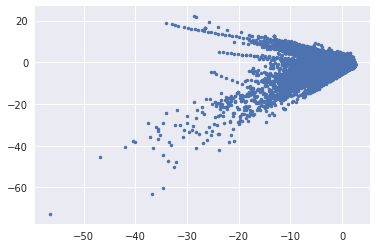

In [15]:
plt.plot(df['V1'], df['V2'],'.')

查看一些特征的分布情况。使用 `sns.distplot()` 查看 `Amount` 和 `Time` 等单个特征的分布情况。

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


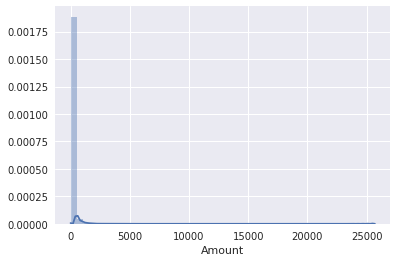

In [16]:
sns.distplot(df['Amount'])

**问题**：`Time` 特征对您有什么帮助？ 再次查看分布情况。您可以从散点图中推断出什么？

**答案**：此分布图与上述 `describe` 函数显示的结果一样。大多数值都接近于 \\100 USD，但也有一些更大的值。

绘制直方图和核密度估计 (KDE) 图。

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


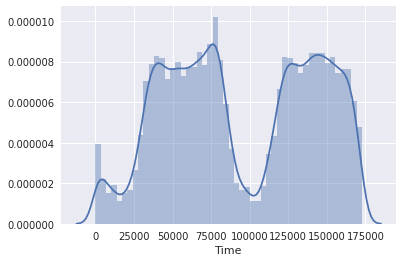

In [17]:
sns.distplot(df['Time'])

时间分布也证实了数据集告诉我们的信息。这些数据包括两天的数据，白天的信用卡交易数量较多，而晚上则较少。

**问题**：对于 `Amount` 列中的欺诈案例，它的分布是什么样的？

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


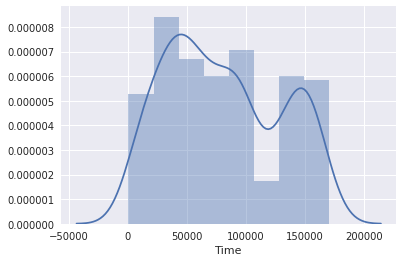

In [18]:
sns.distplot(df[df['Class'] == 1]['Amount'])

下面我们来看一下使用名为 `pairplot` 的 Seaborn 函数展示的分布情况。`pairplot` 可创建一个散点图网格，这样数据集中的每个特征都是一次用作 X 轴，一次用作 Y 轴。此网格的对角线显示了该特征的数据分布情况。

查看 `V1`、`V2`、`V2`、`V4`和 `Class` 的散点图矩阵。您在矩阵中看到了什么？ 您能否从这些特征中区分欺诈和非欺诈？  

**提示**：创建一个新的 DataFrame，包含 `V1`、`V2`、`V4` 和 `Class` 列。

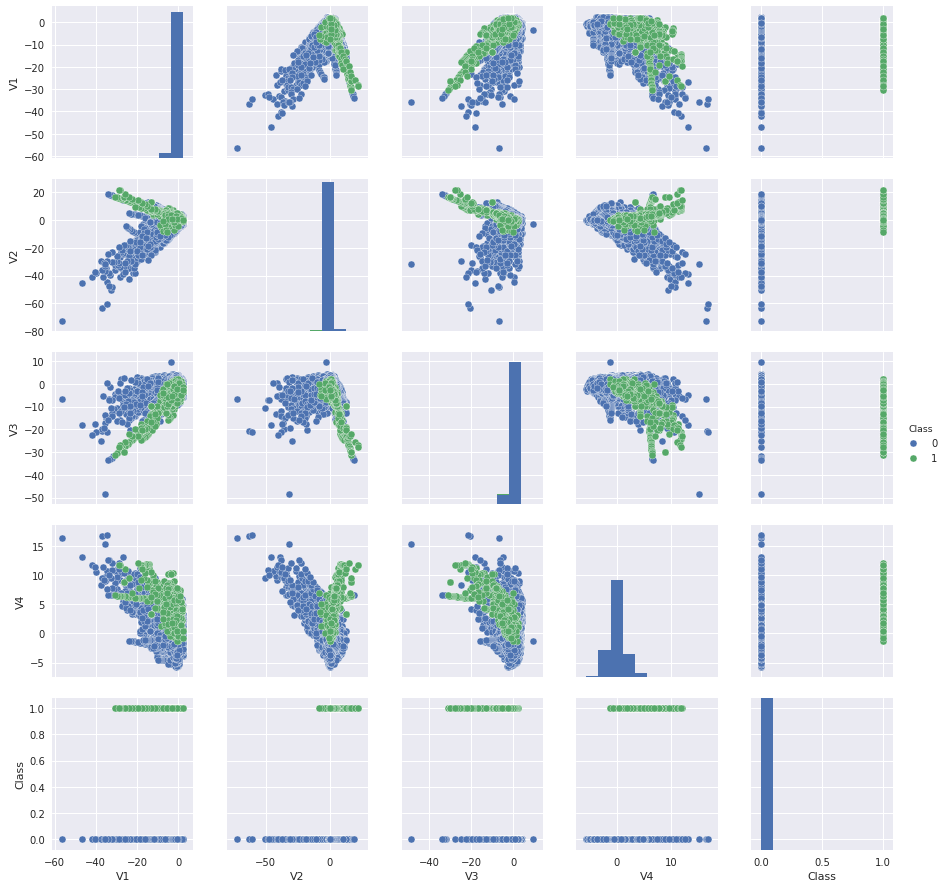

In [19]:
new_df = df[['V1', 'V2', 'V3', 'V4','Class']]
sns.pairplot(new_df, hue="Class")

您可以看到，对于我们使用的小型特征子集，有一种方法可以区分欺诈和非欺诈，但是要根据任何一个特征来区分它们就不容易了。

下面我们来看看这些特征是如何相互作用的。使用 Pandas `corr` 函数计算数据集的特征之间的线性相关性。对相关性进行可视化总是更容易一些。使用 Seaborn heatmap (`sns.heatmap`) 函数绘制相关性图，将 `annot` 标记设置为 `True`。

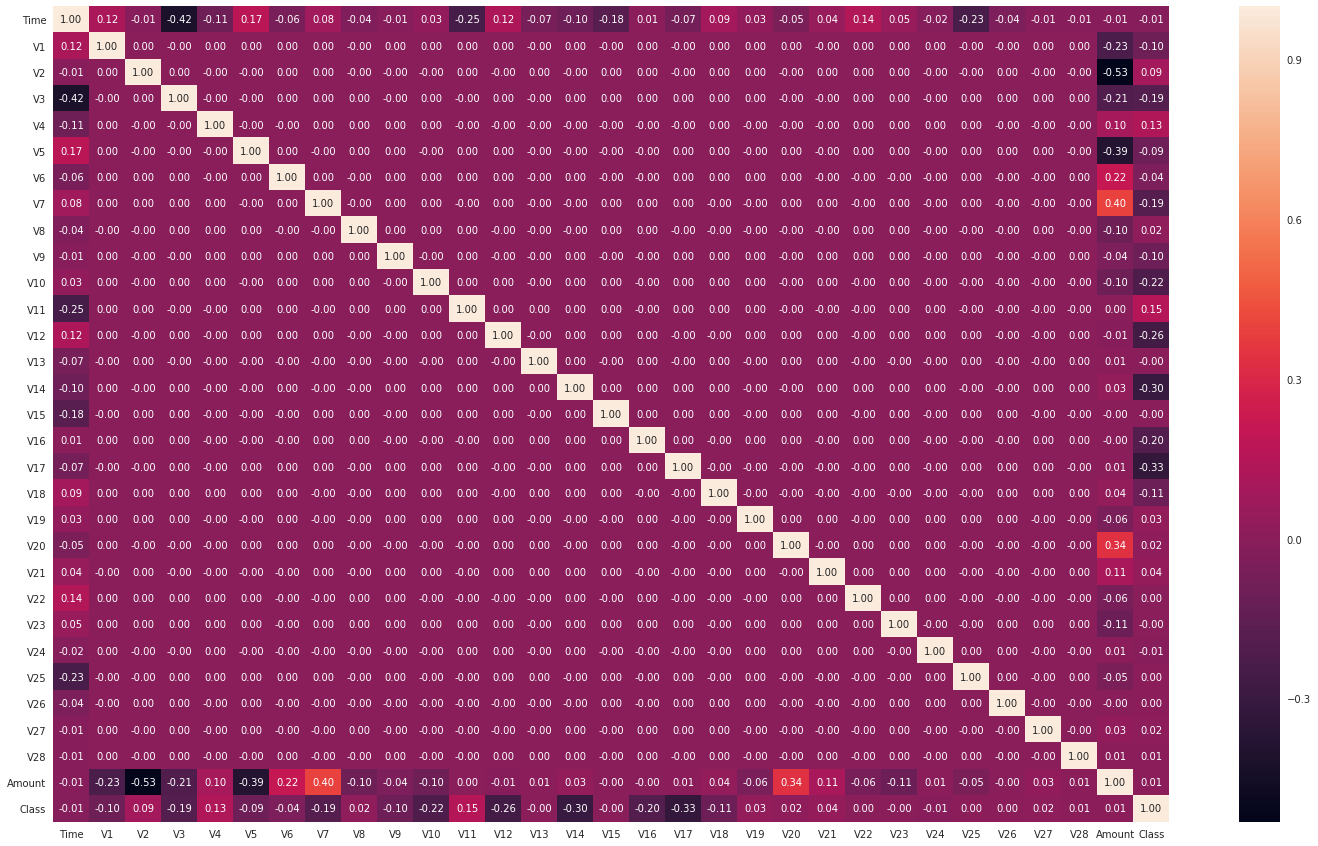

In [20]:
plt.figure(figsize = (25,15))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True,fmt=".2f")

**问题**：对于相关的特征，您应该在进行模型训练之前删除其中一个特征。您有没有发现任何可以删除的特征？

**回答**：没有任何需要删除的相关特征。